## Poroviscoelastic Tides of Io
### Julia notebook
### Hamish Hay (hamish.hay@earth.ox.ac.uk, hcfch1@st-andrews.ac.uk)

This is an accompanying Julia notebook to the paper "Poroviscoelastic Tides of Io" by Hay, Hewitt, Rovira-Navarro, and Katz. This notebook reproduces figures 2-8 in the manuscript. All tidal Love number calculations are performed using [Love.jl](https://github.com/hamishHay/Love.jl), our Love number Julia package. By default, this notebook will mostly load data that has already been generated by `Love.jl`. To freshly generate all data to be plotted, delete all files in the `data` directory. 

In [1]:
using Pkg
Pkg.instantiate()   # Install all dependencies needed to run this notebook

In [2]:
include("./src/plotting_functions.jl")
include("./src/rheology_params.jl")
using Love                  # Package to calculate Tidal Love Numbers
using DataFrames
using SpecialFunctions
using ColorSchemes
using PyPlot
using PyCall
using JLD
using CSV

@pyimport matplotlib as mpl
@pyimport matplotlib.gridspec as gspec
pyimport_conda("cmcrameri.cm", "cmcrameri")
@pyimport cmcrameri.cm as cm    

PyPlot.isjulia_display[] = false;

PyPlot.matplotlib[:rc]("font",family="Arial", weight="medium", style="normal", size=12)
PyPlot.matplotlib[:rc]("axes",titlesize=14.5, labelsize=12, unicode_minus=false)
PyPlot.matplotlib[:rc]("xtick",labelsize=11.5)
PyPlot.matplotlib[:rc]("ytick",labelsize=11.5)
PyPlot.matplotlib[:rc]("pdf",fonttype=42)
PyPlot.matplotlib[:rc]("mathtext", fontset = "stix")

IO_OBVS = ((9.33-1.87)*1e13, (9.33+1.87)*1e13);

isdir("./data") ? nothing : mkdir("./data")
isdir("./figures") ? nothing : mkdir("./figures")

In [3]:
# Convenience function for returning internal structure based on 
# asthensphere thickness
function get_internal_structure(asthenosphere_thickness)    # Input is in km
    R = 1820.0
    r_cmb = 700.0
    r_crust = 1800.0
    r_asthenosphere = r_crust - asthenosphere_thickness

    return [0, r_cmb, r_asthenosphere, r_crust, R] .* 1e3
end;

# Convenience function to calculate the complex moduli for a 
# poroviscoelastic compacting material
function get_complex_moduli(μ, η, κd, ζ, κs, ω)
    μc = zeros(ComplexF64, length(μ))
    κdc = zero(μc)
    αc = zero(μc)
    
    for i in 1:length(μ) 
        μc[i]  =  isinf(η[i]) ? μ[i] : 1im*ω*μ[i] / (1im*ω + μ[i] / η[i])
        κdc[i] =  isinf(ζ[i]) ? κd[i] : 1im*ω*κd[i] / (1im*ω + κd[i] / ζ[i])
        αc[i]  = 1.0 - κdc[i] / κs[i]
    end
    
    return μc, κdc, αc
end

get_complex_moduli (generic function with 1 method)

## Define main material parameters for each layer

In [4]:
n = 2
ω = 2 * 2.05e-5                 # Io rotation rate
ecc = 0.0048                    # Io orbtial eccentricity 

# Number of radial discretisation points per layer
nr_coarse = 50
nr_fine   = 250

# Solid material parameters -------------------------------------------
ρs = [7640, 3300, 3300, 3000]   # Solid density
μ = [60, 60, 60, 60] .* 1e9     # Shear modulus
κs = [100, 200, 200, 200].*1e9  # Solid bulk modulus
η = [1e25, 1e25, 1e30, 1e25]    # Solid shear viscosity
ζ = [1e25, 1e25, 1e0, 1e25]     # Solid compaction viscosity

# Liquid/two-phase material parameters --------------------------------
ρl = [0, 0, 3300.0, 0]          # Liquid density
κl = [0, 0, 100e9, 0]           # Liquid bulk modulus
κd = 0.01κs                     # Compaction modulus
k = [0, 0, 1e-7, 0]             # Permeability
α = 1.0 .- κd ./ κs             # Biot's modulus
ηl = [0, 0, 1, 0]               # Liquid viscosity
ϕ =  [0, 0, 0.1, 0]             # Porosity

ρ = (1 .- ϕ) .* ρs + ϕ .* ρl    # Bulk density

D = 50                          # Asthenosphere thickness in km
r = get_internal_structure(D)   

R = r[end]                      # Mean radius 
rr = expand_layers(r, nr=nr_coarse)    # Discretize primary layers into secondary layers
g = get_g(rr, ρ);               # Calculate g at each secondary layer#

define_spherical_grid(20.0);    # Tell Loves the lat-lon resolution for numerical integration  

## Figure 4 - Darcy heating rate $\dot{E}_D$ versus mobility $M_\phi$

Here we will calculate the Darcy dissipation rate as a function of mobility, Biot's coefficient, and liquid compressibiility. We will assume that the asthenosphere is 50 km thick, and that both shear and compaction deformation is elastic ($\eta\to\infty$, $\zeta\to\infty$). 

As small mobilities can be numerically unstable, we define a different range of moblities to solve over depending on the liquid compressibility.

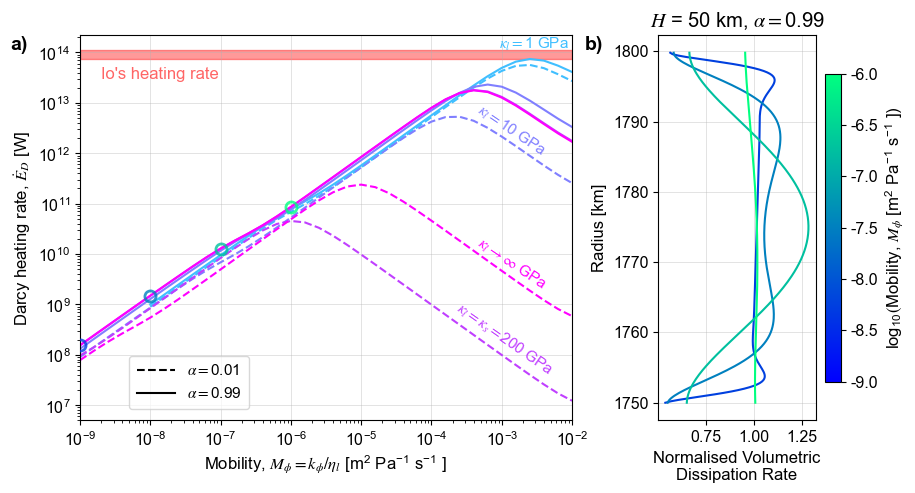

In [5]:
save_file = pwd()*"/data/data_ED.jld"

# Parameters to vary 
ks = [-8:0.2:-1.9, -9:0.2:-1.9, -9:0.2:-1.9, -9:0.2:-1.9]  # Permeability 
Kls = [1, 10, 200, 1e21] * 1e9    # Liquid bulk modulus
κds = [0.99κs, 0.01κs]            # Compaction bulk modulus (and therefore α)

# Preallocate array for Darcy dissipation
El = [[zeros(length(ks[i])) for i in 1:length(Kls)] for j in 1:length(κds)]

D = 50.0                                    # Asthenosphere thickness in km
r = get_internal_structure(D)               # Internal structure
rr = expand_layers(r, nr=nr_coarse)         # Use coarse discretisation 
g = get_g(rr, ρ);   
vol_asth = 4/3. * π * (r[4]^3 - r[3]^3)     # Volume of asthenopshere


if !isfile(save_file)                       # If data file exists, don't recalculate 
    # First caclulate total dissipated power 
    for x in eachindex(κds)
        κd = κds[x]
        α  = 1.0 .- κd ./ κs

        for j in eachindex(Kls)
            κl[3] = Kls[j]

            for i in eachindex(ks[j])
                k[3] = 10.0^ks[j][i]

                # Use only real shear and bulk moduli for elastic behaviour in 
                # shear and compaction
                y1 = compute_y(rr, ρ, g, μ, κs, ω, ρl, κl, κd, α, ηl, ϕ, k);

                Eshear, Ecomp, Edarcy = get_heating_profile(y1, rr, ρ, g, μ, κs, ω, ρl, κl, κd, α, ηl, ϕ, k, ecc)
                El[x][j][i] = Edarcy[1][3]  # Extract the total heating rate from layer 3 (i.e., the asthenopshere)
            end
        end
    end

    # Next calculate heating profiles for select cases.
    r =     get_internal_structure(D)       
    rr =    expand_layers(r, nr=nr_fine)   
    g =     get_g(rr, ρ); 
    
    κd = 0.01κs                                 # Large α limit
    α  = 1 .- κd ./ κs 
    κl = [0.0, 0.0, 1e30, 0.0]                  # Take incompressible melt limit
    ks2 = 10.0 .^ [-9.0, -8.0, -7.0, -6.0]      # Permeabilities 

    El_prof = zeros((nr_fine+1, 4, length(ks2)))
    El_prof_total = zeros((length(ks2)))

    for i in eachindex(ks2)
        k[3] = ks2[i]

        y1 = compute_y(rr, ρ, g, μ, κs, ω, ρl, κl, κd, α, ηl, ϕ, k);
        E1, E2, Edarcy = get_heating_profile(y1, rr, ρ, g, μ, κs, ω, ρl, κl, κd, α, ηl, ϕ, k, ecc)

        El_prof[:,:,i] = Edarcy[2] ./ (Edarcy[1][3] ./ vol_asth)
    end

    save(save_file, "E_Darcy_total", El,
                    "M", [10. .^ collect(i) for i in ks] ./ ηl[3],
                    "E_Darcy_profile", El_prof,
                    "r_profile", rr[1:end-1,3]./1e3, 
                    "M_profile", ks2 ./ ηl[3],
                    "κdx", κds, 
                    "κlx", Kls )

end

fig, axes = plot_darcy_dissipation(save_file)
display(fig)

## Figure 3 - Compaction heating rate $\dot{E}_C$ versus compaction viscosity $\zeta$
Here we will calculate the compaction dissipation rate as a function of $\zeta$, Biot's coefficient, and liquid compressibiility. We will again assume that the asthenosphere is 50 km thick, and hold the mobility of the melt at 1e-7 m² Pa⁻¹ s⁻¹.

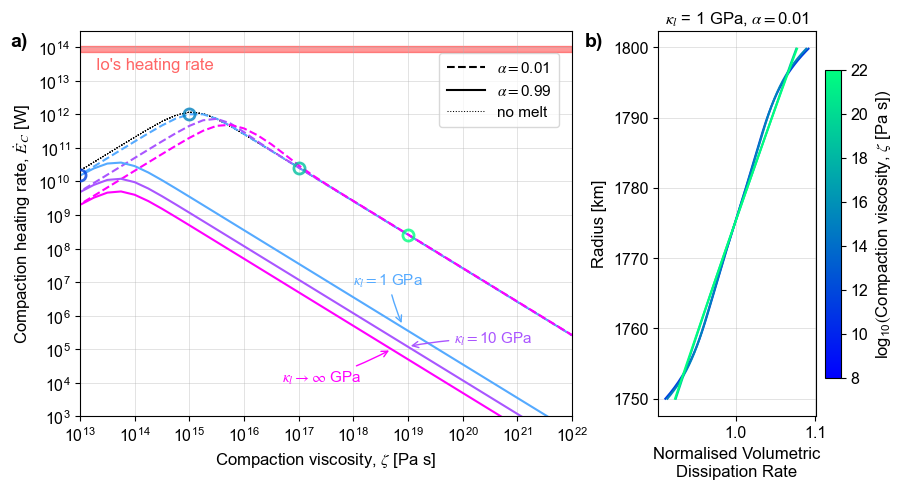

In [6]:
save_file = pwd()*"/data/data_EC.jld"

ηl = [0, 0, 1.0, 0]
k =  [0, 0, 1e-7, 0]    # Set M = 1e-7 m^2 / Pa / s

κs = [100.0, 100.0, 200.0, 100.0] * 1e9
κl = [100.0, 100.0, 100, 100.0] * 1e9

# Parameters to vary
ζs = 8:0.25:22.1
Kls = [1, 10, 1e21] * 1e9
κds = [0.99κs, 0.01κs]

Ec = [[zeros(length(ζs)) for i in 1:length(Kls)] for x in 1:length(κds)]
Ec_nomelt = zeros(length(ζs))

D = 50                                      # Asthenosphere thickness in km
r = get_internal_structure(D)               # Internal structure
rr = expand_layers(r, nr=nr_coarse)         # Discretize primary layers into secondary layers
g = get_g(rr, ρ);    

vol_asth = 4/3. * π * (r[4]^3 - r[3]^3)

if !isfile(save_file)
    for x in eachindex(κds)
        κd[3] = κds[x][3]
        
        for j in eachindex(Kls)
            κl[3] = Kls[j]
            for i in eachindex(ζs)
                ζ[3] = 10.0^ζs[i]

                μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
            
                y1 = compute_y(rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k);
                Eshear, Ecomp, Edarcy = get_heating_profile(y1, rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k, ecc)

                Ec[x][j][i] = Ecomp[1][3]

                if (x==1 && j==1) 
                    μc, κsc, αc = get_complex_moduli(μ, η, κs, ζ, κs, ω)
                    
                    y1 = compute_y(rr, ρ, g, μ, κsc);
                    Eshear, Ecomp = get_heating_profile(y1, rr, ρ, g, μ, κsc, ω, ecc)
                    Ec_nomelt[i] = Ecomp[1][3]
                end
               
            end
        end
    end

    ζs2 = [13, 15, 17, 19]              # Take profiles at these compaction viscosities 
    κd = zero(κs)
    κd[3] = 0.99κs[3]                   # small α
    α  = 1 .- κd ./ κs 

    Ec_prof = zeros((nr_fine+1, 4, length(ζs2)))
    Ec_prof_total = zeros((length(ζs2)))

    r = get_internal_structure(D)            # Internal structure
    rr = expand_layers(r, nr=nr_fine)        # Discretize primary layers into secondary layers
    g = get_g(rr, ρ);     

    for i in eachindex(ζs2)
        ζ[3] = 10.0^ζs2[i]
        κl[3] = Kls[1]
        μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
        
        y1 = compute_y(rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k);
        Eshear, Ecomp, Edarcy = get_heating_profile(y1, rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k, ecc)

        Ec_prof[:,:,i] = Ecomp[2] ./ (Ecomp[1][3] ./ vol_asth)
    end

    save(save_file, "E_Comp_total", Ec,
                    "E_no_melt_total", Ec_nomelt,
                    "ζ", 10. .^ collect(ζs),
                    "E_Comp_profile", Ec_prof,
                    "r_profile", rr[1:end-1,3]./1e3, 
                    "ζ_profile", 10. .^ ζs2,
                    "κdx", κds, 
                    "κlx", Kls )
end

fig, (ax1, ax2) = plot_compaction_dissipation(save_file)
display(fig)

## Figure 2 - Shear heating rate $\dot{E}_S$ versus shear viscosity $\eta$
Here we will calculate the shear dissipation rate as a function of $\eta$, Biot's coefficient, and liquid compressibiility. We will now assume that the asthenosphere is 300 km thick, hold the mobility of the melt at 5e-7 m² Pa⁻¹ s⁻¹, and take compaction to be elastic ($\zeta$ → ∞)

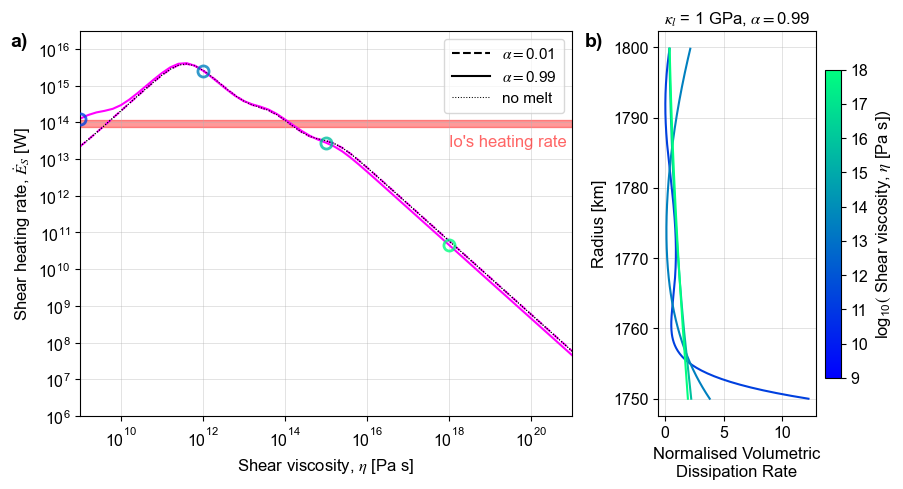

In [7]:
save_file = pwd()*"/data/data_ES.jld"

ηl = [0, 0, 1, 0]
k = [0, 0, 5e-7, 0]
κs = [100.0, 100.0, 200.0, 100.0] * 1e9
κl = [100.0, 100.0, 100, 100.0] * 1e9
Kls = [1.0] * 1e9

# Parameters to vary 
ηs = 9:0.2:21.1         # Shear viscosity for total heating 
ηs2 = [9, 12, 15, 18]   # Shear viscosity for heating profiles
κds = [0.99κs, 0.01κs]  # Biot's coefficient 

Es = [[zeros(length(ηs)) for i in 1:length(Kls)] for x in 1:length(κds)]
Es_nomelt = zeros(length(ηs))

D = 300                              # Asthenosphere thickness in km
r = get_internal_structure(D)        # Internal structure
rr = expand_layers(r, nr=nr_coarse)  # Discretize primary layers into secondary layers
g = get_g(rr, ρ);    

vol_asth = 4/3. * π * (r[4]^3 - r[3]^3)

if !isfile(save_file)
    for x in eachindex(κds)
        κd[3] = κds[x][3]
        
        for j in eachindex(Kls)
            κl[3] = Kls[j]

            for i in eachindex(ηs)
                η[3] = 10.0^ηs[i]

                μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
                
                # Set other layers to be elastic 
                μc[1] = μ[1]
                μc[2] = μ[2]
                μc[4] = μ[4]

                μcf = convert(Array{ComplexF64}, μc)
                
                y1 = compute_y(rr, ρ, g, μc, κs, ω, ρl, κl, κd, α, ηl, ϕ, k);
                Eshear, Ecomp, Edarcy = get_heating_profile(y1, rr, ρ, g, μc, κs, ω, ρl, κl, κd, α, ηl, ϕ, k, ecc)
                
                Es[x][j][i] = Eshear[1][3]

                if (x==1 && j==1) 
                    μc, κsc, αc = get_complex_moduli(μ, η, κs, ζ, κs, ω)
                    μcf = convert(Array{ComplexF64}, μc)
            
                    y1 = compute_y(rr, ρ, g, μc, κs);
                    Eshear, Ecomp = get_heating_profile(y1, rr, ρ, g, μc, κs, ω, ecc)
                    Es_nomelt[i] = Eshear[1][3]
                end
            end
        end
    end

    κd = zero(κs)
    κd[3] = 0.01κs[3] 
    α  = 1 .- κd ./ κs 

    Es_prof = zeros((nr_fine+1, 4, length(ηs2)))
    Es_prof_total = zeros((length(ηs2)))

    r = get_internal_structure(D)       # Internal structure
    rr = expand_layers(r, nr=nr_fine)   # Discretize primary layers into secondary layers
    g = get_g(rr, ρ); 

    for i in eachindex(ηs2)
        η[3] = 10.0^ηs2[i]
        κl[3] = Kls[1]
        μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)

        y1 = compute_y(rr, ρ, g, μc, κs, ω, ρl, κl, κd, α, ηl, ϕ, k);
        Eshear, Ecomp, Edarcy = get_heating_profile(y1, rr, ρ, g, μc, κs, ω, ρl, κl, κd, α, ηl, ϕ, k, ecc)

        
        Es_prof[:,:,i] = Eshear[2] ./ (Eshear[1][3] ./ vol_asth)
    end

    save(save_file, "E_Shear_total", Es,
                    "E_no_melt_total", Es_nomelt,
                    "η", 10. .^ collect(ηs),
                    "E_Shear_profile", Es_prof,
                    "r_profile", rrf[1:end-1,3]./1e3, 
                    "η_profile", 10. .^ ηs2,
                    "κdx", κds, 
                    "κlx", Kls )
end

fig, axes = plot_shear_dissipation(save_file)

display(fig)

## Figure 5 - Rheological parameters dependence on melt fraction $\phi$

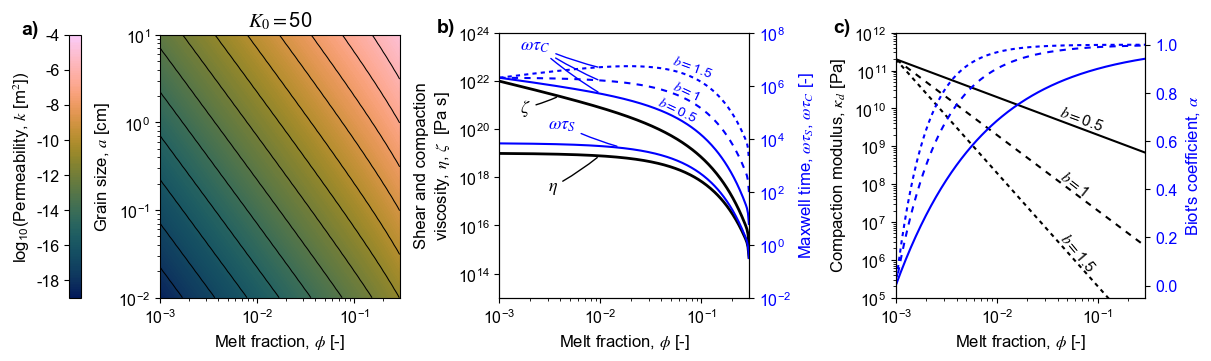

In [8]:
fig, axes = plot_param_vs_phi()     # see functions in rheology_params.jl
display(fig)

## Figure 6 - Dissipation rate versus melt fraction $\phi$ 
Here we adopt the functions defined in Section 4c (Eqs. 4.2 - 4.8) to calculate the total dissipation rate as a function of melt fraction.

In [10]:
# Define dataframe to store data in 
grain_sizes = [0.01, 0.1, 0.2]
Ds = [50.0, 300.0]
# φs = 10 .^ collect(-2:0.025:log10(0.4))
φs = 10 .^ vcat(collect(-2:0.05:-1)[1:end-1], collect(-1:0.01:log10(0.3)))

dgrid = [(i, j, k) for i in grain_sizes, j in Ds, k in φs]

df1 = DataFrame( Dict("a"      => [i[1] for i in dgrid[:]], 
                      "D"      => [i[2] for i in dgrid[:]],
                      "φ"      => [i[3] for i in dgrid[:]],
                      "Etotal" => zeros(length(dgrid)),
                      "Ecomp"  => zeros(length(dgrid)),
                      "Eshear" => zeros(length(dgrid)),
                      "Edarcy" => zeros(length(dgrid)),
                      "Etotal_solid" => zeros(length(dgrid)),
                      "Ecomp_solid"  => zeros(length(dgrid)),
                      "Eshear_solid" => zeros(length(dgrid)),
                      "α"      => zeros(length(dgrid)),
                      "κd"     => zeros(length(dgrid)),
                      "ζ"      => zeros(length(dgrid)),
                      "ηs"     => zeros(length(dgrid)),
                      "k"      => zeros(length(dgrid)) ) )

b = 0.1
df1[!, :ηs] .= Float64.(ηs_phi.(df1[!,:φ], ηl[3]))
df1[!, :κd] .= Float64.(κ_phi.(df1[!,:φ], κs[3], b))
df1[!, :α] .= Float64.( α_phi.(df1[!,:φ], b))
df1[!, :k] .= Float64.( k_phi.(df1[!,:φ], df1[!,:a]))
df1[!, :ζ] .= Float64.( ζ_phi.(df1[!,:φ], df1[!,:ηs]));

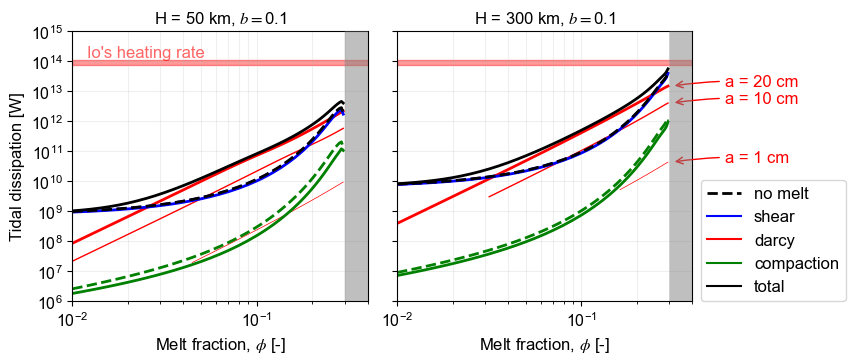

In [12]:
save_name = pwd()*"/data/data_E_vs_phi.csv"
G = 6.67e-11

# Solid material parameters -------------------------------------------
ρs = [7640, 3300, 3300, 3000]   # Solid density
μ = [60, 60, 60, 60] .* 1e9     # Shear modulus
κs = [100, 200, 200, 200].*1e9  # Solid bulk modulus
η = [1e25, 1e25, 1e15, 1e25]    # Solid shear viscosity
ζ = [1e25, 1e25, 1e0, 1e25]    # Solid compaction viscosity

# Liquid/two-phase material parameters --------------------------------
ρl = [0, 0, 3300, 0]                # Liquid density
κl = [0, 0, 1e9, 0]    # Liquid bulk modulus
κd = 0.01κs                         # Drained bulk modulus
k = [0, 0, 1e-7, 0]                 # Permeability
α = 1.0 .- κd ./ κs                    # Biot's modulus

ηl = [0, 0, 1.0, 0]                 # Liquid viscosity
ϕ =  [0, 0, 0.1, 0]           # Porosity

ρ = (1 .- ϕ) .* ρs + ϕ .* ρl        # Bulk density

if !isfile(save_name)
    for i in eachindex(dgrid)
        println("Beginning solve ", i)

        D = df1[i, :D]                      # Asthenosphere thickness in km
        r = get_internal_structure(D)       # Internal structure

        rr = expand_layers(r, nr=nr_fine)        # Discretize primary layers into secondary layers
        g = get_g(rr, ρ);  

        ϕ[3] = df1[i, :φ]
        κd[3] = df1[i, :κd]
        α[3] = df1[i, :α]
        k[3] = df1[i, :k]
        η[3] = df1[i, :ηs]
        ζ[3] = df1[i, :ζ]

        μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
        μc[1] = μ[1]
        μc[2] = μ[2]
        μc[4] = μ[4]

        y1 = compute_y(rr, ρ, g, μc, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k);

        println("   Solution obtained for k=$(k[3])!")

        yR = y1[:,end,end]
        k2 = yR[5] - 1
        println("   Tidal love number is k2=$(k2)")

        # Check for unphysical k2 value
        if abs(real(k2)) < 0.08 && imag(k2) < 0.0 && abs(imag(k2)) < 0.1
            Eshear, Ecomp, Edarcy = get_heating_profile(y1, rr, ρ, g, μc, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k, ecc)

            df1[i, :Eshear] = sum(Eshear[1])
            df1[i, :Ecomp]  = sum(Ecomp[1])
            df1[i, :Edarcy] = sum(Edarcy[1])

            df1[i, :Etotal]  = get_total_heating(y1, ω, R, ecc);
        else
            println("   Unphysical solution. Setting to NaN....")
            df1[i, :Eshear] = NaN 
            df1[i, :Ecomp]  = NaN
            df1[i, :Edarcy] = NaN
            df1[i, :Etotal]  = NaN
        end

        μc, κsc, αc = get_complex_moduli(μ, η, κs, ζ, κs, ω)
        μc[1] = μ[1]
        μc[2] = μ[2]
        μc[4] = μ[4]

        κsc[1] = κs[1]
        κsc[2] = κs[2]
        κsc[4] = κs[4]

        # Kervaso method
        y_solid = compute_y(rr, ρ, g, μc, κsc)

        Eshear, Ecomp = get_heating_profile(y_solid, rr, ρ, g, μc, κsc, ω, ecc)

        df1[i, :Eshear_solid] = sum(Eshear[1])
        df1[i, :Ecomp_solid]  = sum(Ecomp[1])
        df1[i, :Etotal_solid] = get_total_heating(y_solid, ω, rr[end,end], ecc);
    end

    CSV.write(save_name, df1)
end

fig, axes = plot_E_vs_phi(save_name)
display(fig)

## Figure 7 - Sensitivity of compaction dissipation to $b$, $\alpha$, and $\phi$


In [14]:
φs = 10 .^ collect(-3:0.01:log10(0.4))
bs = [1.0, 0.5, 0.25, 0.1, 0.01]

grid2 = [(i, j) for i in φs, j in bs]

df2 = DataFrame( Dict("φ"      => [i[1] for i in grid2[:]],
                      "b"      => [i[2] for i in grid2[:]],
                      "Ebulk"  => zeros(length(grid2)),
                      "Eshear"  => zeros(length(grid2)),
                      "Edarcy"  => zeros(length(grid2)),
                      "Etotal"  => zeros(length(grid2)),
                      "α"      => zeros(length(grid2)),
                      "κd"     => zeros(length(grid2)),
                      "ζ"      => zeros(length(grid2)),
                      "ηs"     => zeros(length(grid2)),
                      "k"      => zeros(length(grid2)) ) )


df2[!, :α] .= Float64.( α_phi.(df2[!,:φ], df2[!,:b] ) )
df2[!, :ηs] .= Float64.(ηs_phi.(df2[!,:φ], ηl[3]))
df2[!, :κd] .= Float64.(κ_phi.(df2[!,:φ], κs[3], df2[!,:b] ))
df2[!, :k] .= 1e-6   #Float64.( k_phi.(df2[!,:φ], 0.1)) # 10cm grain size
df2[!, :ζ] .= Float64.( ζ_phi.(df2[!,:φ], df2[!,:ηs]));

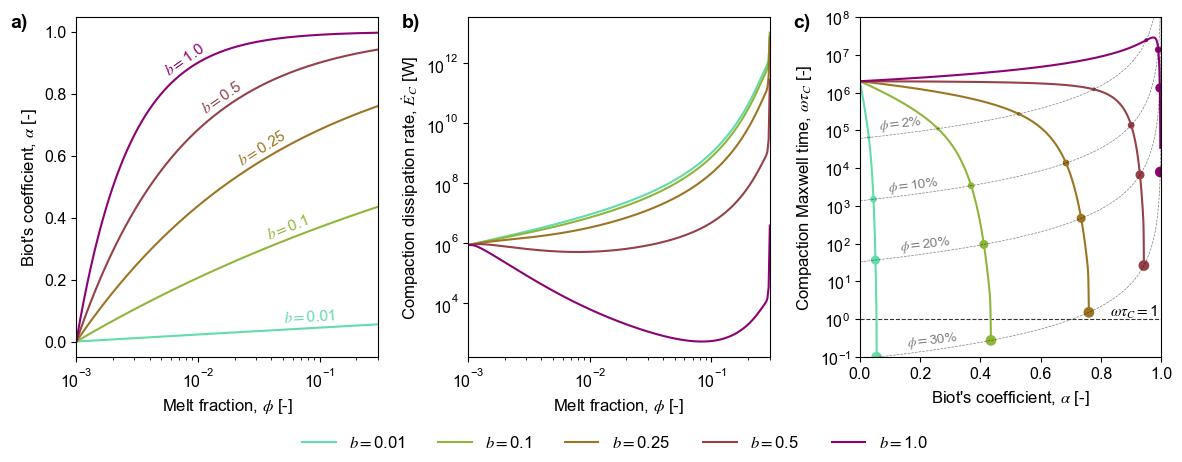

In [15]:
save_name = pwd()*"/data/data_E_vs_b.csv"

G = 6.67e-11

# Solid material parameters -------------------------------------------
# ρs = prec[3300, 3300, 3300, 3300]   # Solid density
ρs = [7640, 3300, 3300, 3000] 
μ = [60, 60, 60, 60] .* 1e9     # Shear modulus
κs = [100, 200, 200, 200].*1e9  # Solid bulk modulus
η = [1e25, 1e25, 1e15, 1e25]    # Solid shear viscosity
ζ = [1e25, 1e25, 1e0, 1e25]    # Solid compaction viscosity

# Liquid/two-phase material parameters --------------------------------
ρl = [0, 0, 3300, 0]                # Liquid density
κl = [0, 0, 1e9, 0]    # Liquid bulk modulus
κd = 0.01κs                         # Drained bulk modulus
k = [0, 0, 1e-7, 0]                 # Permeability
α = 1.0 .- κd ./ κs                    # Biot's modulus

ηl = [0, 0, 1.0, 0]                 # Liquid viscosity
ϕ =  [0, 0, 0.1, 0]           # Porosity

ρ = (1 .- ϕ) .* ρs + ϕ .* ρl        # Bulk density

D = 300                           # Asthenosphere thickness in km
r = get_internal_structure(D)       # Internal structure

R = r[end]                          # Mean radius 
nr = 500                        # Number of radial layers
rr = expand_layers(r, nr=nr)        # Discretize primary layers into secondary layers
g = get_g(rr, ρ);  

if !isfile(save_name)
    for i in eachindex(grid2)
        println("Beginning solve ", i)

        ϕ[3] = df2[i, :φ]
        κd[3] = df2[i, :κd]
        α[3] = df2[i, :α]
        k[3] = df2[i, :k]
        η[3] = df2[i, :ηs]
        ζ[3] = df2[i, :ζ]

        μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
        μc[1] = μ[1]
        μc[2] = μ[2]
        μc[4] = μ[4]

        if k[3] > 5e-10
            y1 = compute_y(rr, ρ, g, μc, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k);
            y1 = ComplexF64.(y1)

            println("   Solution obtained for k=$(k[3])!")

            yR = y1[:,end,end]
            k2 = yR[5] - 1
            println("   Tidal love number is k2=$(k2)")

            # Check for unphysical k2 value
            if abs(real(k2)) < 0.08 && imag(k2) < 0.0 && abs(imag(k2)) < 0.1
                Eshear, Ecomp, Edarcy = get_heating_profile(y1, rr, ρ, g, μc, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k, ecc)

                df2[i, :Eshear]  = sum(Eshear[1])
                df2[i, :Ebulk]  = sum(Ecomp[1])
                df2[i, :Edarcy]  = sum(Edarcy[1])
            else
                println("   Unphysical solution. Setting to NaN....")
                df2[i, :Eshear]  = NaN
                df2[i, :Ebulk]  = NaN
                df2[i, :Edarcy]  = NaN
            end
        else
            println("   Porosity too high: Unphysical solution. Setting to NaN....")
            df2[i, :Eshear]  = NaN
            df2[i, :Ebulk]  = NaN
            df2[i, :Edarcy]  = NaN
        end

    end

    CSV.write(save_name, df2)

end    

fig, axes = plot_b_sensitivity(save_name)
display(fig)

## Figure 8 - Tidal dissipation patterns
Here we will calculate the tidal heating patterns associated with optimal rheological parameters

In [16]:
G = 6.67e-11

define_spherical_grid(2.0);

# Solid material parameters -------------------------------------------
ρs = [7640, 3300, 3300, 3000] 
μ = [60, 60, 60, 60] .* 1e9     # Shear modulus
κs = [100, 200, 200, 200].*1e9  # Solid bulk modulus
η = [1e25, 1e25, 8e13, 1e25]    # Solid shear viscosity
ζ = [1e25, 1e25, 1e0, 1e25]     # Solid compaction viscosity

# Liquid/two-phase material parameters --------------------------------
ρl = [0, 0, 3300, 0]                # Liquid density
κl = [0, 0, 1e9, 0]                 # Liquid bulk modulus
κd = 0.01κs                         # Drained bulk modulus
k = [0, 0, 1e-7, 0]                 # Permeability
α = 1.0 .- κd ./ κs                 # Biot's modulus
ηl = [0, 0, 1.0, 0]                 # Liquid viscosity
ϕ =  [0, 0, 0.1, 0]                 # Porosity

ρ = (1 .- ϕ) .* ρs + ϕ .* ρl        # Bulk density

D = 300                             # Asthenosphere thickness in km
r = get_internal_structure(D)       # Internal structure

R = r[end]                          # Mean radius 
nr = 100                            # Number of radial layers
rr = expand_layers(r, nr=nr)        # Discretize primary layers into secondary layers
g = get_g(rr, ρ);  

map_shear = zeros((length(Love.clats), length(Love.lons)))
map_bulk = zero(map_shear)
map_darcy = zero(map_shear)

α_comp = 0.0
α_darcy = 0.0
ωζ_comp = 0.0

for i in 1:3
    # Shear dissipation
    if i==1
        η[3] = 2e14

        μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
        y1 = compute_y(rr, ρ, g, μc, κs, ω, ρl, κl, κd, α, ηl, ϕ, k);
        
    # Compaction dissipation 
    elseif i==2
        b = 0.01
        ϕ[3] = 0.29
        η[3] = ηs_phi(ϕ[3], ηl[3])
        ζ[3] = ζ_phi(ϕ[3], η[3])
        α[3]  = α_phi(ϕ[3], b)
        κd[3] = κ_phi(ϕ[3], κs[3], b)
        k[3]  = k_phi(ϕ[3], 0.2)

        ωζ_comp = ω * ζ[3] / κd[3]
        
        α_comp = α[3]
        μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
        y1 = compute_y(rr, ρ, g, μc, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k);

    # Darcy dissipation
    else
        ϕ[3] = 0.29
        η[3] = 1e21
        ζ[3] = 1e21
        α[3]  = 0.99
        κd[3] = (1 - α[3])*κs[3]
        k[3]  = 1e-5
        
        α_darcy = α[3]
        μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)

        y1 = compute_y(rr, ρ, g, μc, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k);
    end
    
    if i==1
        map_shear, temp, temp = get_heating_map(conj.(y1), rr, ρ, g, μc, κs, ω, ρl, κl, κd, α, ηl, ϕ, k, ecc)
    elseif i==2
        temp, map_bulk, temp = get_heating_map(conj.(y1), rr, ρ, g, μ, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k, ecc)
    else
        temp,temp, map_darcy = get_heating_map(conj.(y1), rr, ρ, g, μc, κs, ω, ρl, κl, κdc, αc, ηl, ϕ, k, ecc)
    end
end

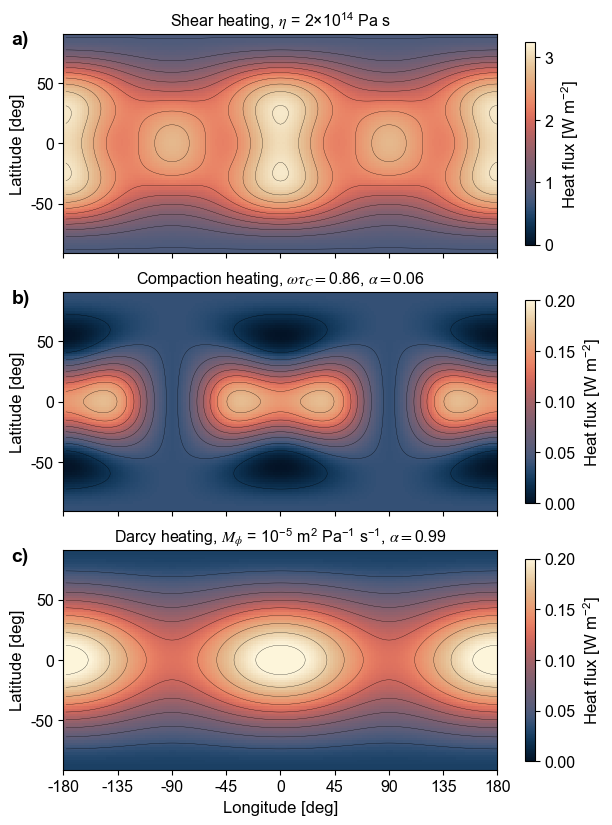

In [17]:
define_spherical_grid(2.0);

cmap = ColorMap(ColorSchemes.lajolla.colors[:])
cmap = ColorMap(ColorSchemes.lipari.colors[:])

fig, (ax1, ax2, ax3) = subplots(nrows=3, figsize=(7, 10), sharex=true)

axes = [ax1, ax2, ax3]

lons = 180 .- rad2deg.(Love.lons)[:]
lats = 90 .- rad2deg.(Love.clats)
lvl_comp = 0:0.02:0.21
lvl_shear = 0:0.26:3.6

c3 = ax3.pcolor(lons, lats, map_darcy, cmap=cmap, vmin=0.0, vmax=0.2, rasterized=true)
ax3.contour(lons, lats, map_darcy, levels=lvl_comp, linewidths=0.2, colors="k")
c2 = ax2.pcolor(lons, lats, map_bulk, cmap=cmap, vmin=0.0, vmax=0.2, rasterized=true)
ax2.contour(lons, lats, map_bulk, levels=lvl_comp, linewidths=0.2, colors="k")
c1 = ax1.pcolor(lons, lats, map_shear, cmap=cmap, vmin=0.0, vmax=3.25, rasterized=true)
ax1.contour(lons, lats, map_shear, levels=lvl_shear, linewidths=0.2, colors="k")

clabel = "Heat flux [W m\$^{\\mathregular{-2}}\$]"
colorbar(c1, orientation="vertical", label=clabel, shrink=0.8)
colorbar(c2, orientation="vertical", label=clabel, shrink=0.8)
colorbar(c3, orientation="vertical", label=clabel, shrink=0.8)

tick_loc = collect(-180:45:180)
for ax in axes
    ax.set_aspect("equal")
    ax.set_ylabel("Latitude [deg]")
    ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(tick_loc)) 
    ax.set_xlim([-180, 180])
end

ax1.text(-0.12, 0.95, "a)", fontsize=14, fontweight="bold", transform=ax1.transAxes)
ax2.text(-0.12, 0.95, "b)", fontsize=14, fontweight="bold", transform=ax2.transAxes)
ax3.text(-0.12, 0.95, "c)", fontsize=14, fontweight="bold", transform=ax3.transAxes)

ax3.set_title("Darcy heating, \$M_\\phi\$ = 10\$^{\\mathregular{-5}}\$ m\$^\\mathregular{2}\$ Pa\$^\\mathregular{-1}\$ s\$^\\mathregular{-1}\$, \$\\alpha = \\mathregular{$(α_darcy)}\$", fontsize=11.5)
ax2.set_title("Compaction heating, \$\\omega\\tau_C=\\mathregular{$(round(ωζ_comp;digits=2))}\$, \$\\alpha = \\mathregular{$(round(α_comp; digits=2))}\$" , fontsize=11.5)
ax1.set_title("Shear heating, \$\\eta\$ = 2×10\$^{\\mathregular{14}}\$ Pa s", fontsize=11.5)



# ax3.set_title("Darcy heating\n\$\\phi = \\mathregular{0.3}\$, \$a = \\mathregular{10}\$ cm, \$M_\\phi\$ = 10\$^{\\mathregular{-5}}\$ m\$^\\mathregular{2}\$ Pa\$^\\mathregular{-1}\$ s\$^\\mathregular{-1}\$, \$b=\\mathregular{0.8}\$, \$\\alpha = \\mathregular{$(α_darcy)}\$", fontsize=13)
# ax2.set_title("Compaction heating\n\$\\phi = \\mathregular{0.3}\$, \$\\omega\\tau_C=\\mathregular{$(round(ωζ_comp;digits=2))}\$, \$b=\\mathregular{0.01}\$, \$\\alpha = \\mathregular{$(round(α_comp; digits=2))}\$" , fontsize=13)
# ax1.set_title("Shear heating\n\$\\eta\$ = 2×10\$^{\\mathregular{14}}\$ Pa s", fontsize=13)

ax3.set_xlabel("Longitude [deg]")

subplots_adjust(hspace=0.02)

fig.savefig("./figures/fig8_heating_patterns.pdf", dpi=400, bbox_inches="tight")

display(fig)

define_spherical_grid(10.0);

## Supplementary figures

Here we will compare the method of this work/K23 with the approach of RN22.

First, we must load in a version of our tidal Love number code that follows RN22:

In [18]:
include("./src/LoveRN22.jl");

Next we define a dataframe for the model results

In [19]:
# Make new data frame to save results

grain_sizes = [0.2]
Ds = [50.0]
φs = 10 .^ collect(-2:0.025:log10(0.4))

grid = [(i, j, k) for i in grain_sizes, j in Ds, k in φs]

df3 = DataFrame( Dict("a"      => [i[1] for i in grid[:]], 
                      "D"      => [i[2] for i in grid[:]],
                      "φ"      => [i[3] for i in grid[:]],
                      "Etotal1" => zeros(length(grid)),
                      "Ebulk1"  => zeros(length(grid)),
                      "Eshear1" => zeros(length(grid)),
                      "Edarcy1" => zeros(length(grid)),
                      "Etotal2" => zeros(length(grid)),
                      "Ebulk2"  => zeros(length(grid)),
                      "Eshear2" => zeros(length(grid)),
                      "Edarcy2" => zeros(length(grid)),
                      "α"      => zeros(length(grid)),
                      "κd"     => zeros(length(grid)),
                      "ζ"      => zeros(length(grid)),
                      "ηs"     => zeros(length(grid)),
                      "k"      => zeros(length(grid)) ) )

b = 0.1
df3[!, :ηs] .= ηs_phi.(df3[!,:φ], ηl[3])
df3[!, :κd] .= κ_phi.(df3[!,:φ], κs[3], b)
df3[!, :α] .=  α_phi.(df3[!,:φ], b)
df3[!, :k] .=  k_phi.(df3[!,:φ], df3[!,:a])
df3[!, :ζ] .=  ζ_phi.(df3[!,:φ], df3[!,:ηs]);

Now we will solve for the tidal heating rate as a function of melt fraction and compare the results.

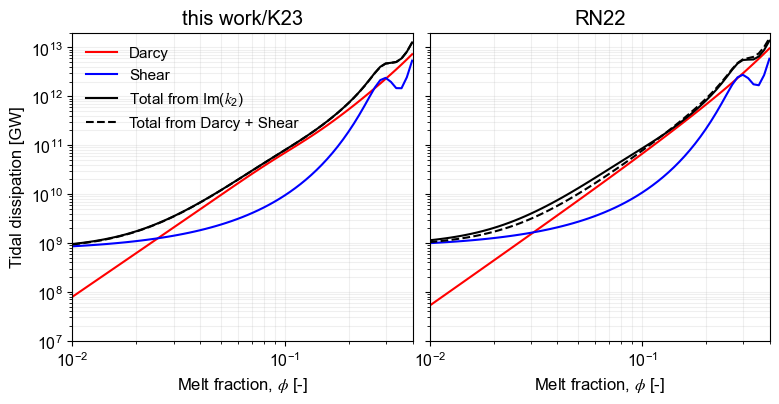

In [20]:
save_name = "./data/data_RN22.csv"

# Solid material parameters -------------------------------------------
ρs = [7640, 3300, 3300, 3000] 
μ = [60, 60, 60, 60] .* 1e9     # Shear modulus
κs = [100, 200, 200, 200].*1e9  # Solid bulk modulus
η = [1e25, 1e25, 8e13, 1e25]    # Solid shear viscosity
ζ = [1e25, 1e25, 1e0, 1e25]     # Solid compaction viscosity

# Liquid/two-phase material parameters --------------------------------
ρl = [0, 0, 3300, 0]            # Liquid density
κl = [0, 0, 1e9, 0]             # Liquid bulk modulus
κd = 0.01κs                     # Drained bulk modulus
k = [0, 0, 1e-7, 0]             # Permeability
α = 1.0 .- κd ./ κs             # Biot's modulus

ηl = [0, 0, 1.0, 0]             # Liquid viscosity
ϕ =  [0, 0, 0.1, 0]             # Porosity

ρ = (1 .- ϕ) .* ρs + ϕ .* ρl    # Bulk density

if !isfile(save_name)
    for i in eachindex(grid)
        D = df3[i, :D]                      # Asthenosphere thickness in km
        r = get_internal_structure(D)       # Internal structure

        rr = expand_layers(r, nr=nr_fine)        # Discretize primary layers into secondary layers
        g = get_g(rr, ρ);  

        ϕ[3] = df3[i, :φ]
        κd[3] = df3[i, :κd]
        α[3] = df3[i, :α]
        k[3] = df3[i, :k]
        η[3] = df3[i, :ηs]
        ζ[3] = df3[i, :ζ]

        μc, κdc, αc = get_complex_moduli(μ, η, κd, ζ, κs, ω)
        μc[1] = μ[1]
        μc[2] = μ[2]
        μc[4] = μ[4]
        
        y1 = compute_y(rr, ρ, g, μc, κs, ω, ρl, κl, κd, α, ηl, ϕ, k);

        LoveRN22.α = α[3]
        y2 = LoveRN22.calculate_y(rr, ρ, g, μc, κs, ω, ρl, κl, ηl, ϕ, k);
        y2[8,:,:] .*= ϕ[3] * 1im * ω

        E11, E12, E13 = get_heating_profile(y1, rr, ρ, g, μc, κs, ω, ρl, κl, κd, α, ηl, ϕ, k, ecc; lay=3)
        E21, E22, E23 = get_heating_profile(y2, rr, ρ, g, μc, κs, ω, ρl, κl, κd, α, ηl, ϕ, k, ecc)

        df3[i, :Eshear1] = sum(E11[1])
        df3[i, :Ebulk1]  = sum(E12[1])
        df3[i, :Edarcy1] = sum(E13[1])

        df3[i, :Etotal1]  = get_total_heating(y1, ω, R, ecc);

        df3[i, :Eshear2] = sum(E21[1])
        df3[i, :Ebulk2]  = sum(E22[1])
        df3[i, :Edarcy2] = sum(E23[1])

        df3[i, :Etotal2]  = get_total_heating(y2, ω, R, ecc);
    end

    CSV.write(save_name, df3)
end

fig, axes = plot_RN22(save_name)
display(fig)